In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
from torch.optim import lr_scheduler
from tempfile import TemporaryDirectory

In [2]:
if torch.cuda.is_available():
    # Set the device to CUDA (GPU 0)
    device = torch.device("cuda:0")
else:
    # If no GPU is available, fall back to CPU
    device = torch.device("cpu")

In [3]:
base_path = "/home/intern/Documents/King_Hang/School/"
# os.chdir(BASE_PATH)

# path to animal classes
ANIMALS_PATH = './animals'

# Use only images in training folder
STYLE_ANIMALS_PATH = './style_animals/train/' 

In [4]:
from torchvision import transforms

data_dir = os.getcwd()
BATCH_SIZE = 4
IMAGE_SIZE = (224, 224)

transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define a custom dataset
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name)
        label = int(self.dataframe.iloc[idx, 2])

        if self.transform:
            image = self.transform(image)

        return image, label

### Create dataloaders

1. Animals
2. Stylized Animals

#### 1. Animals

##### Visualize

##### Data Augmentation, create datasets, create dataloaders

In [5]:
def create_dataloaders(path: str):
    data = {"imgpath": [] , "labels": [] }

    category = os.listdir(path)
    for folder in category:
        folderpath = os.path.join(path , folder)
        filelist = os.listdir(folderpath)
        for file in filelist:
            fpath = os.path.join(folderpath, file)
            data["imgpath"].append(fpath)
            data["labels"].append(folder)

    df = pd.DataFrame(data) 

    #Convert labels to numbers
    lb = LabelEncoder()
    df['encoded_labels'] = lb.fit_transform(df['labels'])

    # Split data into train-valid-test
    train_df, Temp_df = train_test_split(df,  train_size= 0.70 , shuffle=True, random_state=124)
    valid_df , test_df = train_test_split(Temp_df ,  train_size= 0.70 , shuffle=True, random_state=124)
    train_df = train_df.reset_index(drop=True)
    valid_df = valid_df.reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)

    print("----------Train-------------")
    print(train_df[["imgpath", "labels"]].head(5))
    print(train_df.shape)
    print("--------Validation----------")
    print(valid_df[["imgpath", "labels"]].head(5))
    print(valid_df.shape)
    print("----------Test--------------")
    print(test_df[["imgpath", "labels"]].head(5))
    print(test_df.shape)

    plt.figure(figsize=(8,5))
    for i, row in test_df.sample(n=4).reset_index().iterrows():
        plt.subplot(2,2,i+1)
        image_path = row['imgpath']
        image = Image.open(image_path)
        plt.imshow(image)
        plt.title(row["labels"])
        plt.axis('off')
    plt.show()

    data_dir = os.getcwd()
    BATCH_SIZE = 4
    IMAGE_SIZE = (224, 224)


    # create datasets
    trainset = ImageDataset(dataframe=train_df, root_dir=data_dir, transform=transform)
    validset = ImageDataset(dataframe=valid_df, root_dir=data_dir, transform=transform)
    testset = ImageDataset(dataframe=test_df, root_dir=data_dir, transform=transform)

    # create dataloaders
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                            shuffle=True, num_workers=2)
    validloader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE,
                                            shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                            shuffle=False, num_workers=2)

    dataset_sizes = {'train': len(train_df), 'val': len(valid_df), 'test': len(test_df)}

    return trainloader, validloader, testloader, dataset_sizes

----------Train-------------
                               imgpath      labels
0        ./animals/wolf/7e89ab5ef0.jpg        wolf
1   ./animals/porcupine/0e0854d5fa.jpg   porcupine
2  ./animals/rhinoceros/5fcc6f58cd.jpg  rhinoceros
3         ./animals/fox/19f72b1098.jpg         fox
4         ./animals/pig/3bcf2188bc.jpg         pig
(3779, 3)
--------Validation----------
                            imgpath   labels
0    ./animals/horse/8d296dbe0a.jpg    horse
1     ./animals/wolf/07c803c409.jpg     wolf
2    ./animals/whale/8a2694dc7c.jpg    whale
3     ./animals/crab/28a44015b4.jpg     crab
4  ./animals/lobster/407c310e07.jpg  lobster
(1134, 3)
----------Test--------------
                                imgpath       labels
0         ./animals/moth/85a538cff7.jpg         moth
1  ./animals/caterpillar/5c475568d9.jpg  caterpillar
2      ./animals/raccoon/051a2d3733.jpg      raccoon
3       ./animals/donkey/92ec6a9100.jpg       donkey
4         ./animals/crab/1eb3673642.jpg         crab

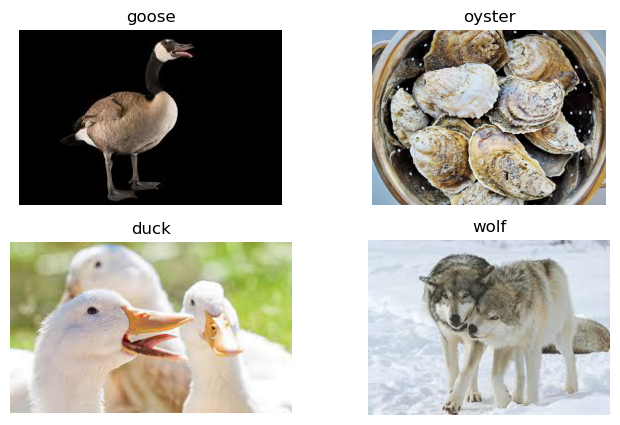

In [6]:
trainloader, validloader, testloader, dataset_sizes = create_dataloaders(ANIMALS_PATH)
dataloaders = {'train': trainloader, 'val': validloader, 'test': testloader}

##### Stylized Animals

----------Train-------------
                                           imgpath      labels
0        ./style_animals/train/wolf/7e89ab5ef0.jpg        wolf
1   ./style_animals/train/porcupine/0e0854d5fa.jpg   porcupine
2  ./style_animals/train/rhinoceros/5fcc6f58cd.jpg  rhinoceros
3         ./style_animals/train/fox/19f72b1098.jpg         fox
4         ./style_animals/train/pig/3bcf2188bc.jpg         pig
(3779, 3)
--------Validation----------
                                        imgpath   labels
0    ./style_animals/train/horse/8d296dbe0a.jpg    horse
1     ./style_animals/train/wolf/07c803c409.jpg     wolf
2    ./style_animals/train/whale/8a2694dc7c.jpg    whale
3     ./style_animals/train/crab/28a44015b4.jpg     crab
4  ./style_animals/train/lobster/407c310e07.jpg  lobster
(1134, 3)
----------Test--------------
                                            imgpath       labels
0         ./style_animals/train/moth/85a538cff7.jpg         moth
1  ./style_animals/train/caterpillar/5c4755

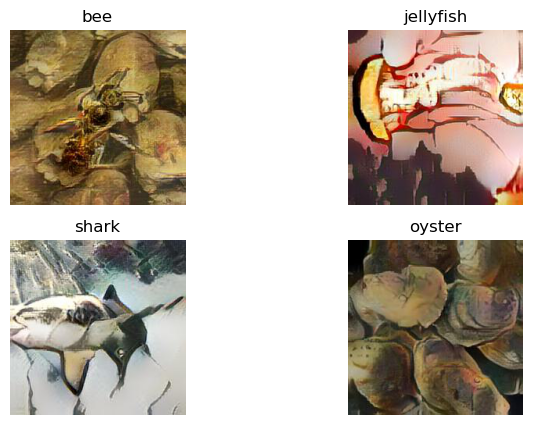

In [7]:
s_trainloader, s_validloader, s_testloader, s_dataset_sizes = create_dataloaders(STYLE_ANIMALS_PATH)
s_dataloaders = {'train': s_trainloader, 'val': s_validloader, 'test':s_testloader}

#### Accuracy and Top 5 Accuracy

Top-5 accuracy provides a more forgiving evaluation metric by considering whether the correct class is within the top 5 predicted classes. This is especially relevant in image recognition, where there can be a vast number of object categories. 

High top-5 accuracy indicates that the model is not only good at picking the most likely class but also capable of recognizing other plausible classes. 

It's especially useful when comparing models that have similar performance on the top-1 (single most likely class) accuracy but differ in their ability to provide a ranked list of possible classes.

In [2]:
def get_accuracy(model, testloader):

    model.eval()
    model = model.to(device)
    correct = 0
    total = 0
    predictions = list()

    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Record predictions
            predictions.append(outputs)

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

    return predictions

def top_5_accuracy(predictions, labels):
    _, top5_predictions = torch.topk(predictions, 5, dim=1)
    correct = top5_predictions.eq(labels.view(-1, 1).expand_as(top5_predictions))
    top5_acc = correct.sum().item() / len(labels)
    return top5_acc

##### Training code

In [8]:
import time
# From Official Pytorch page: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
def train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
            
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [9]:
import sys

T_PATH = './texture-vs-shape/models/'

sys.path.append(T_PATH)

In [10]:
from load_pretrained_models import load_model

model_A = "resnet50_trained_on_SIN"
model_B = "resnet50_trained_on_SIN_and_IN"
model_C = "resnet50_trained_on_SIN_and_IN_then_finetuned_on_IN"

### Model A without ANY finetuning

In [13]:
model = load_model(model_name = model_A)

Using the ResNet50 architecture.


/home/robert/anaconda3/envs/torch114/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/robert/anaconda3/envs/torch114/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [14]:
predictions = get_accuracy(model, testloader)

Test Accuracy: 0.41%


In [15]:
model.eval()  # Set the model to evaluation mode
top5_acc_total = 0.0

with torch.no_grad():
    for inputs, labels in testloader:
        # Assuming 'model' is your trained model
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        top5_acc_batch = top_5_accuracy(outputs, labels)
        top5_acc_total += top5_acc_batch

average_top5_accuracy = top5_acc_total / len(testloader)
print(f"Top-5 Accuracy: {average_top5_accuracy * 100:.2f}%")

Top-5 Accuracy: 3.07%


### Model B without ANY finetuning

In [16]:
model = load_model(model_name = model_B)

Using the ResNet50 architecture.


/home/robert/anaconda3/envs/torch114/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/robert/anaconda3/envs/torch114/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [17]:
predictions = get_accuracy(model, testloader)

Test Accuracy: 0.82%


In [18]:
model.eval()  # Set the model to evaluation mode
top5_acc_total = 0.0

with torch.no_grad():
    for inputs, labels in testloader:
        # Assuming 'model' is your trained model
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        top5_acc_batch = top_5_accuracy(outputs, labels)
        top5_acc_total += top5_acc_batch

average_top5_accuracy = top5_acc_total / len(testloader)
print(f"Top-5 Accuracy: {average_top5_accuracy * 100:.2f}%")

Top-5 Accuracy: 3.28%


### Model C without ANY finetuning

In [20]:
model = load_model(model_name = model_C)

Using the ResNet50 architecture.


/home/robert/anaconda3/envs/torch114/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/robert/anaconda3/envs/torch114/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [21]:
predictions = get_accuracy(model, testloader)

Test Accuracy: 0.21%


In [22]:
model.eval()  # Set the model to evaluation mode
top5_acc_total = 0.0

with torch.no_grad():
    for inputs, labels in testloader:
        # Assuming 'model' is your trained model
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        top5_acc_batch = top_5_accuracy(outputs, labels)
        top5_acc_total += top5_acc_batch

average_top5_accuracy = top5_acc_total / len(testloader)
print(f"Top-5 Accuracy: {average_top5_accuracy * 100:.2f}%")

Top-5 Accuracy: 2.66%
